In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

import cartopy.crs as ccrs

import torch
import torch.nn as nn
import torch.utils.data as data
import torch_geometric
from torch.nn import Sequential as Seq, Linear, ReLU
from Networks import *
from Data_Functions import *
from matplotlib.animation import FuncAnimation
from Utils import *
from Subgrid_Funcs import *
import torch.distributed as dist

from Parallel import *
from Eval_Funcs import *
from torch.utils.data import Dataset, DataLoader
import os 
import sys
import random
import copy


In [11]:
exp_num_in = "3"
exp_num_extra = "12"
exp_num_out = "2"


mse = torch.nn.MSELoss()

region = "Tropics_Ext"   
network = "U_net"


interval = 2

N_samples = 2000
N_val = 100
# N_samples = 750
# N_val = 100
N_test = 1000

factor = 10

hist = 0

lag = 1

steps = 1

Nb = 4 

if len(sys.argv) > 4:
    n_cond = int((len(sys.argv)-4)/2)

str_video = ""

try:
    for i in range(n_cond):
        if type(globals()[sys.argv[int(4 + i*2)]]) == str:
            temp = str(sys.argv[int(5 + i*2)])
            exec(sys.argv[int(4 + i*2)] +"= temp" )
            if sys.argv[int(4 + i*2)] == "network":
                continue
            str_video += "_" + sys.argv[int(4 + i*2)] + "_" + sys.argv[int(5 + i*2)]
        elif type(globals()[sys.argv[int(4 + i*2)]]) == int:
            exec(sys.argv[int(4 + i*2)] +"=" + "int(" + sys.argv[int(5 + i*2)] +")" )
            str_video += "_" + sys.argv[int(4 + i*2)] + "_" + sys.argv[int(5 + i*2)]
    print(str_video)
except:
    print("no cond")

    
if region == "Kuroshio":
    lat = [15,41]
    lon = [-215, -185]
elif region == "Kuroshio_Ext":
    lat = [5,50]
    lon = [-250, -175]      
elif region == "Gulf_Stream":
    lat = [25, 50]
    lon = [-70,-35]
elif region == "Gulf_Stream_Ext":
    lat = [27, 50]
    lon = [-82,-35]       
elif region == "Tropics":
    lat = [-5,25]
    lon = [-95,-65]  
elif region == "Tropics_Ext":
    lat = [-5,25]
    lon = [-115,-45]     
elif region == "South_America":
    lat = [-60, -30]
    lon = [-70,-35] 
elif region == "Africa":
    lat = [-50, -20]
    lon = [5,45] 
elif region == "Quiescent":
    lat = [-42.5, -17.5]
    lon = [-155,-120] 
elif region == "Quiescent_Ext":
    lat = [-55, -10]
    lon = [-170,-110]            
elif region == "Pacific":
    lat = [-35, 35]
    lon = [-230,-80]     
elif region == "Indian":
    lat = [-30, 28]
    lon = [30,79]     
    
    
s_train = lag*hist
e_train = s_train + N_samples*interval
e_test = e_train + interval*N_val



device = "cuda"


inpt_dict = {"1":["um","vm"],"2":["um","vm","ur","vr"],"3":["um","vm","Tm"],
            "4":["um","vm","ur","vr","Tm","Tr"],"5":["ur","vr"],"6":["ur","vr","Tr"],
            "7":["Tm"],"8":["Tm","Tr"],"9":["u","v"],"10":["u","v","T"],
            "11":["tau_u","tau_v"],"12":["tau_u","tau_v","t_ref"]} 
extra_dict = {"1":["ur","vr"],"2":["ur","vr","Tm"],
            "3":["Tm"],"4":["ur","vr","Tm","Tr"],"5":[],"6":["um","vm"],
             "7":["um","vm","Tm"], "8": ["um","vm","Tm","Tr"],
              "9":["ur","vr","tau_u","tau_v"],"10":["tau_u","tau_v"],
              "11":["t_ref"],"12":["tau_u","tau_v","t_ref"],
             "13":["ur","vr","Tr","tau_u","tau_v","t_ref"]} 
out_dict = {"1":["um","vm"],"2":["um","vm","Tm"],"3":["ur","vr"],
           "4":["ur","vr","Tr"],"5":["u","v"],"6":["u","v","T"]}

grids = xr.open_dataset('/scratch/zanna/data/CM2_grids/Grid_cm25_Vertices.nc')

if region == "global_25":
    grids = xr.open_dataset('/scratch/zanna/data/CM2_grids/Grid_cm25_Vertices.nc')

elif "global" in region:
    grids = coarse_grid(grids,factor)

else:
    grids = grids.sel({"yu_ocean":slice(lat[0],lat[1]),"xu_ocean":slice(lon[0],lon[1])})


area = torch.from_numpy(grids["area_C"].to_numpy()).to(device=device)

inputs = inpt_dict[exp_num_in]
extra_in = extra_dict[exp_num_extra]
outputs = out_dict[exp_num_out]

str_in = "".join([i + "_" for i in inputs])
str_ext = "".join([i + "_" for i in extra_in])
str_out = "".join([i + "_" for i in outputs])

print("inputs: " + str_in)
print("extra inputs: " + str_ext)
print("outputs: " + str_out)

N_atm = len(extra_in)
N_in = len(inputs)
N_extra = N_atm + N_in
N_out = len(outputs)

num_in = int((hist+1)*N_in + N_extra)


inputs, extra_in, outputs = gen_data_025_lateral(inputs,extra_in,outputs,lag,lat,lon,Nb)

wet = xr.zeros_like(inputs[0][0])
# inputs[0][0,12,12] = np.nan
for data in inputs:
    wet +=np.isnan(data[0])
wet = np.isnan(xr.where(wet==0,np.nan,0))
wet = np.nan_to_num(wet.to_numpy())
wet = torch.from_numpy(wet).type(torch.float32).to(device="cpu")
wet_bool = np.array(wet.cpu()).astype(bool)

time_vec = inputs[0].time.data

no cond
inputs: um_vm_Tm_
extra inputs: tau_u_tau_v_t_ref_
outputs: um_vm_Tm_


/scratch/as15415/Emulation/Data_Functions.py:619: UserWarning: rename 'lat' to 'yu_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yu_ocean","lon":"xu_ocean"})
/scratch/as15415/Emulation/Data_Functions.py:619: UserWarning: rename 'lon' to 'xu_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yu_ocean","lon":"xu_ocean"})


In [12]:
data_in_test = gen_data_in_test(0,e_test,N_test,lag,hist,inputs,extra_in)

data_out_test = gen_data_out_test(0,e_test,N_test,lag,hist,outputs)

test_data = data_CNN_Lateral(data_in_test,data_out_test,wet.to(device = "cpu"),N_atm,Nb,device=device) 

# time_test = time_vec[e_test:(e_test+lag*N_test)]

mean_out = test_data.norm_vals['m_out']  
std_out = test_data.norm_vals['s_out']  

In [13]:
N_run = 5
len_run = 200
for ns in [4000]:
    for rand_ind in range(1,4):
        data_shape = test_data[0][1].shape
        model_pred = np.zeros((int(N_run*len_run),data_shape[1],data_shape[2],data_shape[0]))        

        for i in range(N_run):
            print(ns,rand_ind)
            if network == "CNN":
                model = CNN(num_in = num_in, num_out = N_out, num_channels = 64,num_layers = 5,kernel_size=3)
            elif network == "U_net":
                model = U_net([num_in,64,128,256,512],N_out,wet.to(device=device))
            elif network == "U_net_RK":
                model = U_net_RK([num_in,64,128,256,512],N_out,wet)
            model.to(device=device);
#             model.load_state_dict(torch.load("/scratch/as15415/Emulation/Networks/"+network+"_Parallel_"+region+"_Test_in_"+str_in+"ext_"+str_ext+"N_train_1000_region_"+region+"_N_samples_1000_lam_0.pt",map_location=torch.device(device)))
#             model.load_state_dict(torch.load("/scratch/as15415/Emulation/Networks/U_net_Parallel_Fast_masked_"+region+"_Test_in_"+str_in+"ext_"+str_ext+"_out"+str_in+"N_train_"+str(2000)+"_region_"+region+"_rand_seed_"+str(rand_ind)+"_lam_"+str(ns)+"_Lateral_Data_025.pt",map_location=torch.device(device)))
#             model.load_state_dict(torch.load("/scratch/as15415/Emulation/Networks/U_net_Parallel_Fast_"+region+"_Test_in_"+str_in+"ext_"+str_ext+"_out"+str_in+"N_train_"+str(2000)+"_region_"+region+"_rand_seed_"+str(rand_ind)+"_lam_"+str(ns)+"_Lateral_Data_025.pt",map_location=torch.device(device)))
#             model.load_state_dict(torch.load("/scratch/as15415/Emulation/Networks/U_net_Parallel_Fast_"+region+"_Test_in_"+str_in+"ext_"+str_ext+"_out"+str_in+"N_train_"+str(2000)+"_region_"+region+"_rand_seed_"+str(rand_ind)+"_steps_"+str(ns)+"_Lateral_Data_025.pt",map_location=torch.device(device)))
#             model.load_state_dict(torch.load("/scratch/as15415/Emulation/Networks/U_net_Parallel_Fast_"+region+"_Test_in_"+str_in+"ext_"+str_ext+"_out"+str_in+"N_train_"+str(2000)+"_region_"+region+"_rand_seed_"+str(rand_ind)+"_steps_"+str(ns)+"_Lateral_Data_025.pt",map_location=torch.device(device)))
            model.load_state_dict(torch.load("/scratch/as15415/Emulation/Networks/U_net_Parallel_Fast_"+region+"_Test_in_"+str_in+"ext_"+str_ext+"_out"+str_in+"N_train_"+str(ns)+"_region_"+region+"_rand_seed_"+str(rand_ind)+"_N_samples_"+str(ns)+"_Lateral_Data_025_no_smooth.pt",map_location=torch.device(device)))

#         model.load_state_dict(torch.load("/scratch/as15415/Emulation/Networks/U_net_Parallel_"+region+"_Test_in_"+str_in+"ext_"+str_ext+"_out"+str_out+"N_train_750_region_"+region+"_rand_seed_"+str(rand_ind)+"_steps_"+str(step)+".pt",map_location=torch.device(device)))
            temp = copy.deepcopy(test_data)   
            temp.input = temp.input[int(i*len_run):int((i+1)*len_run)]
            temp.output = temp.output[int(i*len_run):int((i+1)*len_run)]
            temp.size = len_run

            model_pred_temp = recur_pred_lateral(len_run,temp,model,hist,N_in,N_extra,Nb)
            print("data_gen")
            model_pred[int(i*len_run):int((i+1)*len_run)] = model_pred_temp

        da = xr.DataArray(
            data=model_pred,
            dims=["time","x", "y","var"],
        )

        da.to_zarr("/scratch/as15415/Emulation/Preds/Pred_Short_Data_025_"+region+"_in_"+str_in+"ext_"+str_ext+"N_samples_"+str(ns)+"_rand_seed_"+str(rand_ind)+".zarr",mode="w")

4000 1
data_gen
4000 1
data_gen
4000 1
data_gen
4000 1
data_gen
4000 1
data_gen
4000 2
data_gen
4000 2
data_gen
4000 2
data_gen
4000 2
data_gen
4000 2
data_gen
4000 3
data_gen
4000 3
data_gen
4000 3
data_gen
4000 3
data_gen
4000 3
data_gen


In [12]:
print(int(i*len_run),int((i+1)*len_run))

800 1000


In [103]:


for i in range(5):
    ns = 100
    rand_ind = 1
    data_shape = test_data[0][1].shape
    if network == "CNN":
        model = CNN(num_in = num_in, num_out = N_out, num_channels = 64,num_layers = 5,kernel_size=3)
    elif network == "U_net":
        model = U_net([num_in,64,128,256,512],N_out,wet.to(device=device))
    elif network == "U_net_RK":
        model = U_net_RK([num_in,64,128,256,512],N_out,wet)
    model.to(device=device);
    #         model.load_state_dict(torch.load("/scratch/as15415/Emulation/Networks/"+network+"_Parallel_"+region+"_Test_in_"+str_in+"ext_"+str_ext+"N_train_1000_region_"+region+"_N_samples_1000_lam_0.pt",map_location=torch.device(device)))
    model.load_state_dict(torch.load("/scratch/as15415/Emulation/Networks/U_net_Parallel_Fast_"+region+"_Test_in_"+str_in+"ext_"+str_ext+"_out"+str_in+"N_train_"+str(2000)+"_region_"+region+"_rand_seed_"+str(rand_ind)+"_lam_"+str(ns)+"_Lateral_Data_025.pt",map_location=torch.device(device)))
    #         model.load_state_dict(torch.load("/scratch/as15415/Emulation/Networks/U_net_Parallel_"+region+"_Test_in_"+str_in+"ext_"+str_ext+"_out"+str_out+"N_train_750_region_"+region+"_rand_seed_"+str(rand_ind)+"_steps_"+str(step)+".pt",map_location=torch.device(device)))

    temp = copy.deepcopy(test_data)   
    temp.input = temp.input[int(i*len_run):int((i+1)*len_run)]
    temp.output = temp.output[int(i*len_run):int((i+1)*len_run)]
    temp.size = len_run
    print(i)
    model_pred_temp = recur_pred_lateral(200,temp,model,hist,N_in,N_extra,Nb)
    model_pred[int(i*len_run):int((i+1)*len_run)] = model_pred_temp


0
1
2
3
4


In [108]:
mean_atm,auto_mean = compute_mean(1000,test_data,model_pred,area.cpu(),wet_bool)
rmse_atm,auto_rmse = compute_rmse(1000,test_data,model_pred,area.cpu(),wet_bool)


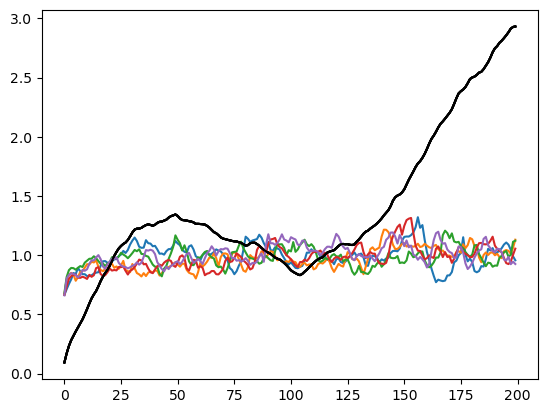

In [112]:
for i in range(N_run):
    plt.plot(rmse_atm[int(i*len_run):int((i+1)*len_run),2])
    plt.plot(auto_rmse[:len_run,2],"k")
    